In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [155]:
class Z_P_Optimizer(object):
    ''' 
    Generates a C from standard uniform, then determines corresponding Z and P
    - N is number of loci,
    - M is number of samples,
    - C_num is number of clustered clones
    '''
    
    def __init__(self, loci_num=5, samples_num=5, clones_num=3):
        self.N = loci_num
        self.M = samples_num
        self.C_num = clones_num
    
    def draw_C_matrix(self, print_bool=False):
        ''' Draw a C matrix from standard uniform given dimensions '''
        C_matrix = np.zeros((self.N, self.M))
        for col in range(self.N):
            for row in range(self.M):
                C_matrix[row][col] = np.random.uniform()
        if print_bool:
            print(C_matrix)
        return C_matrix
    
    def enumerate_Z_cols(self, print_bool=False):
        ''' List possible columns for a Z matrix given dimensions '''
        possible_Z_cols = []
        for num_ones in range(self.N):
            possible_Z_cols += [np.bincount(xs, minlength=(self.N)).tolist()\
                           for xs in itertools.combinations(range(self.N), (num_ones+1))]
        return possible_Z_cols
    
    def generate_Zs(self):
        ''' Generate possible Z matrices '''
        possible_Z_cols = self.enumerate_Z_cols()
        np.random.shuffle(possible_Z_cols)
        combos = itertools.combinations(possible_Z_cols, (self.C_num))
        possible_Zs = [np.array(c).T for c in combos]
        return possible_Zs
    
    def scale_P(self, P_in, print_bool=False):
        ''' Create a valid P matrix by dropping negative probabilities and forcing
            columns to sum to 1 '''
        P_out = np.zeros((self.C_num, self.M))
        for col_num in range(self.M):
            curr_col = P_in[:,col_num]
            dropped_negs = [c if c>0 else 0 for c in curr_col]
            scaled = dropped_negs / np.sum(dropped_negs)
            P_out[:,col_num] = scaled
        if print_bool:
            print(P_out)
        return P_out
    
    def generate_Zs_Ps_error(self):
        ''' Generate corresponding P matrices from Z and C
            Returns Zs, valid Ps, and sum of residuals (squared Euclidean 2-norm) '''
        C_matrix = self.draw_C_matrix()
        possible_Zs = self.generate_Zs()
        possible_Ps = []
        errors = []
        for possible_Z in possible_Zs:
            curr_P_solved = np.linalg.lstsq(possible_Z, C_matrix)
            curr_P_scaled = self.scale_P(curr_P_solved[0])
            curr_resids = (C_matrix - np.dot(possible_Z, curr_P_scaled))**2
            curr_error = np.sum(np.sum(curr_resids))
            possible_Ps.append(curr_P_scaled)
            errors.append(curr_error)
        return (possible_Zs, possible_Ps, errors)
    
    def plot_errors(self):
        ''' Plot error graph (x-axis is enumerated Z, y-axis is sum of residuals) '''
        Zs, Ps, errs = self.generate_Zs_Ps_error()
        plt.figure()
        plt.plot(errs)
        plt.title('Sum of Squared Euclidean 2-Norms Vs Enumerated Z')
        plt.xlabel('Enumerated Z index')
        plt.ylabel('Sum of Residuals')
        plt.show()
        
    def optimal_Z_P(self, C_in=None, print_bool=False):
        ''' Generate optimal Z and P given a generated C, or pass in C as input '''
        if C_in == None:
            C_matrix = self.draw_C_matrix()
        else:
            C_matrix = C_in
        Zs, Ps, errs = self.generate_Zs_Ps_error()
        min_index = np.argmin(errs)
        optimals = Zs[min_index], Ps[min_index], errs[min_index]
        if print_bool:
            print('Input C:')
            for row in C_matrix:
                print(row)
            print()
            print('Optimal Z:')
            for row in Zs[min_index]:
                print(row)
            print()
            print('Optimal P:')
            for row in Ps[min_index]:
                print(row)
            print()
            print('Error:')
            print(errs[min_index])
        return optimals

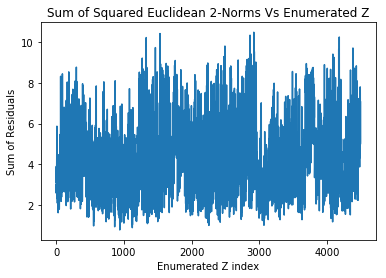

In [158]:
opt = Z_P_Optimizer()
opt.plot_errors()

In [160]:
z_opt, p_opt, err_opt = opt.optimal_Z_P(print_bool=True)

Input C:
[ 0.14002701  0.09339353  0.60407433  0.6208501   0.79795465]
[ 0.42775514  0.61776917  0.07214448  0.91975247  0.71712662]
[ 0.23710541  0.04969988  0.33276276  0.86543634  0.62344616]
[ 0.0769311   0.17553549  0.34281903  0.09111558  0.95750815]
[ 0.60304589  0.6323414   0.36072169  0.71794592  0.17026575]

Optimal Z:
[0 1 0]
[1 1 0]
[1 0 1]
[1 0 0]
[0 1 0]

Optimal P:
[ 0.          0.          0.07083252  0.37859035  0.60146844]
[ 0.42327199  0.30319497  0.7543355   0.62140965  0.18173207]
[ 0.57672801  0.69680503  0.17483197  0.          0.21679949]

Error:
0.89301933408
